### Samsung electronics

In [18]:
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
start_date = '2014-01-01'
end_date = '2024-03-25'
ticker = '005930'

data = pdr.DataReader(ticker, 'naver', start=start_date, end=end_date).astype(float)
data.index = pd.to_datetime(data.index)

In [27]:
data['Returns'] = data['Close'].pct_change()
data['Cumulative Returns'] = (1 + data['Returns']).cumprod() - 1

In [28]:
data

,Open,High,Low,Close,Volume,Returns,Cumulative Returns
Date,,,,,,,
2014-01-02,26960.0,27100.0,26040.0,26180.0,620500.0,NaN,NaN
2014-01-03,26000.0,26220.0,25740.0,25920.0,529932.0,-0.009931,-0.009931
2014-01-06,26060.0,26399.0,25920.0,26140.0,394716.0,0.008488,-0.001528
2014-01-07,26000.0,26360.0,25900.0,26080.0,395264.0,-0.002295,-0.003820
2014-01-08,26000.0,26080.0,25740.0,25820.0,409493.0,-0.009969,-0.013751
...,...,...,...,...,...,...,...
2024-03-19,72300.0,73000.0,71700.0,72800.0,15376066.0,0.000000,1.780749
2024-03-20,73700.0,77200.0,73400.0,76900.0,50106297.0,0.056319,1.937357
2024-03-21,79200.0,79300.0,77700.0,79300.0,44569799.0,0.031209,2.029030


In [22]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

days = (i for i in range(3, 62, 2))
threshold = tuple([-i * 0.01 for i in range(3, 21)])

items = [(i, j) for i in days for j in threshold]

In [23]:
return_data = pd.DataFrame(index = data.index)

for i in range(1, 501) :
    return_data['-' + str(i) + 'days'] = (data['Close'] - data['Close'].shift(i)) / data['Close']

In [24]:
return_data.to_csv('samsung_returns_data.csv')
return_data.to_excel('samsung_returns_data.xlsx')

In [25]:
return_data.index = range(len(return_data))

In [31]:
dataframes = dict()
dataframes_plot = dict()

for d, thres in tqdm(items) :
    thres = round(-thres * 100, 1)
    dataframes[f'day{d}_{thres}per'] = pd.DataFrame(index = data.index)
    dataframes_plot[f'day{d}_{thres}per_plot'] = pd.DataFrame(index = data.index)
    for i in range(1, 501) :
        temp = ((1 + data['Cumulative Returns'].iloc[return_data[return_data[str(-i) + 'days'] < -thres * 0.01][:-d].index + d]) / (1 + data['Cumulative Returns'].iloc[return_data[return_data[str(-i) + 'days'] < -thres * 0.01][:-d].index].values)) - 1
        dataframes[f'day{d}_{thres}per'] = pd.concat(
            [dataframes[f'day{d}_{thres}per'], temp], axis = 1
        )
        dataframes_plot[f'day{d}_{thres}per_plot'] = pd.concat(
            [dataframes_plot[f'day{d}_{thres}per_plot'], temp], axis = 0
        )
    dataframes[f'day{d}_{thres}per'].columns = [str(-i) + 'days' for i in range(1, 501)]
    dataframes[f'day{d}_{thres}per'].to_excel(f'./excel/Samsung_day{d}_{int(thres)}per.xlsx')

100%|██████████| 540/540 [2:05:02<00:00, 13.89s/it]  


In [32]:
def statsplot(index, data, thresh, ticker : str) :
    plt.figure(figsize = (8, 8))
    plt.subplot(2, 2, 1)
    plt.plot(
        index, [i.mean() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-0.05, 0.25])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('mean')
    
    plt.subplot(2, 2, 2)
    plt.plot(
        index, [i.std() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-0.05, 0.2])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('standard dev')
    
    plt.subplot(2, 2, 3)
    plt.plot(
        index, [i.skew() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-1, 1])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('skewness')
    
    plt.subplot(2, 2, 4)
    plt.plot(
        index, [i.kurt() for i in data],
        marker = '.'
    )
    plt.grid(False)
    #plt.ylim([-1, 2.2])
    plt.axhline(0, color = 'gray', alpha = 0.75, ls = '-.')
    plt.title('kurtosis')
    
    plt.tight_layout()
    
    plt.suptitle(f'sim_thresh : {thresh}% | market : {ticker} | start : {start_date} | end : {end_date}')
    plt.tight_layout()
    
    filename = f'./figure/{ticker}_distribution_{thresh}percent.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    return None

def pipeline(threshold, days, dataframes, ticker) :
    values = []

    for i in days :
        values.append(
            dataframes[f"day{i}_{threshold}.0per"].iloc[:,1:].stack().reset_index(drop=True)
        )
    
    statsplot(days, values, threshold, ticker)
    return None

In [36]:
days = [i for i in range(3, 62, 2)]

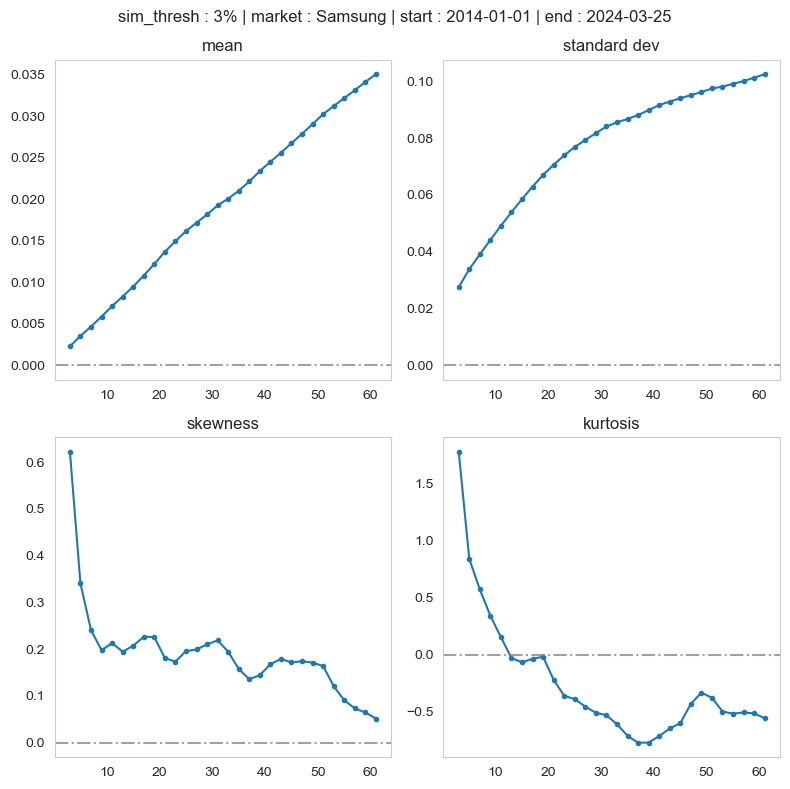

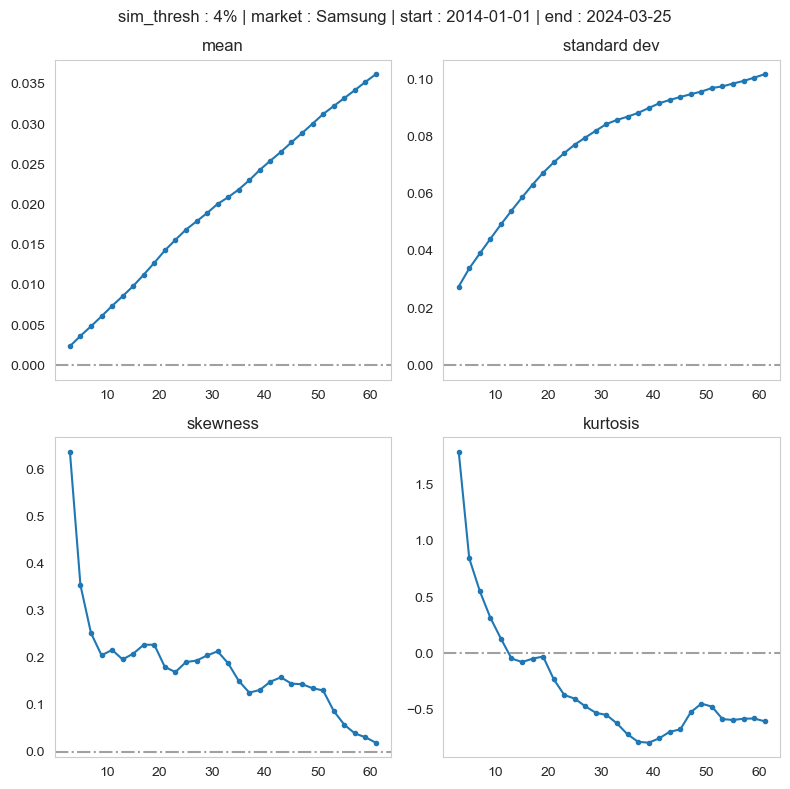

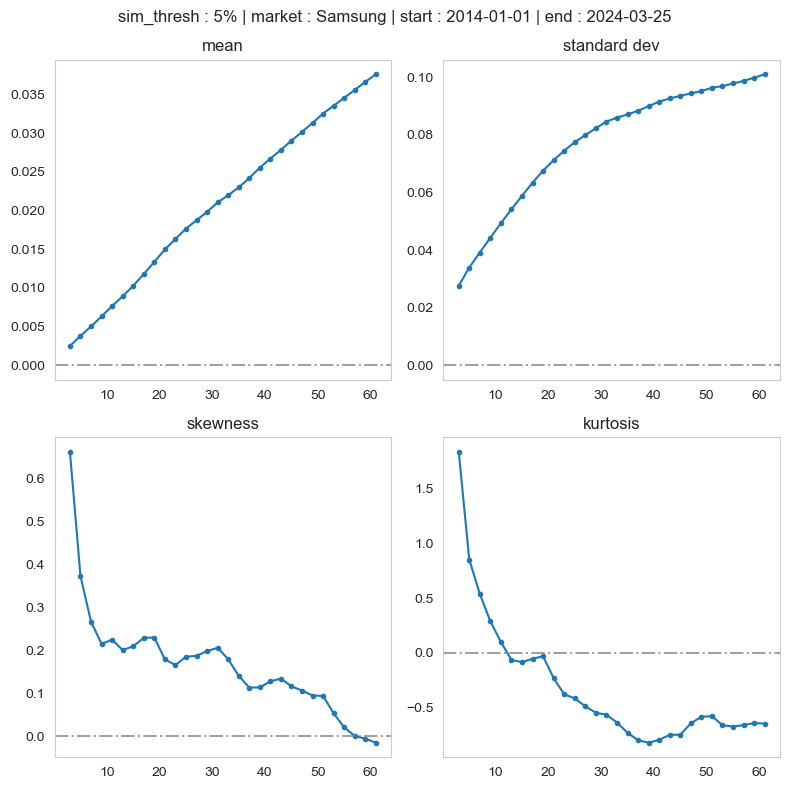

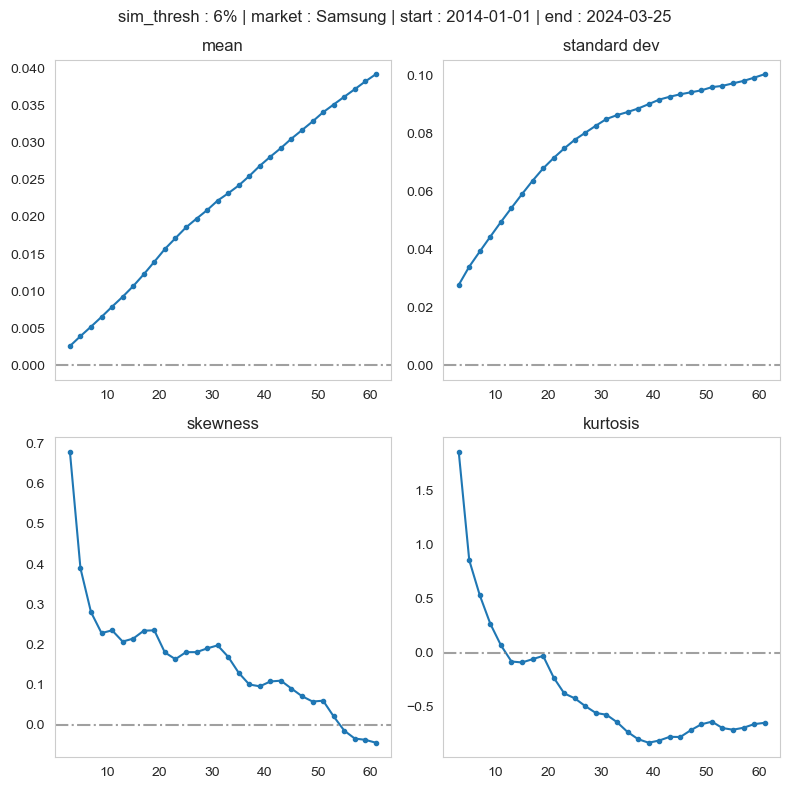

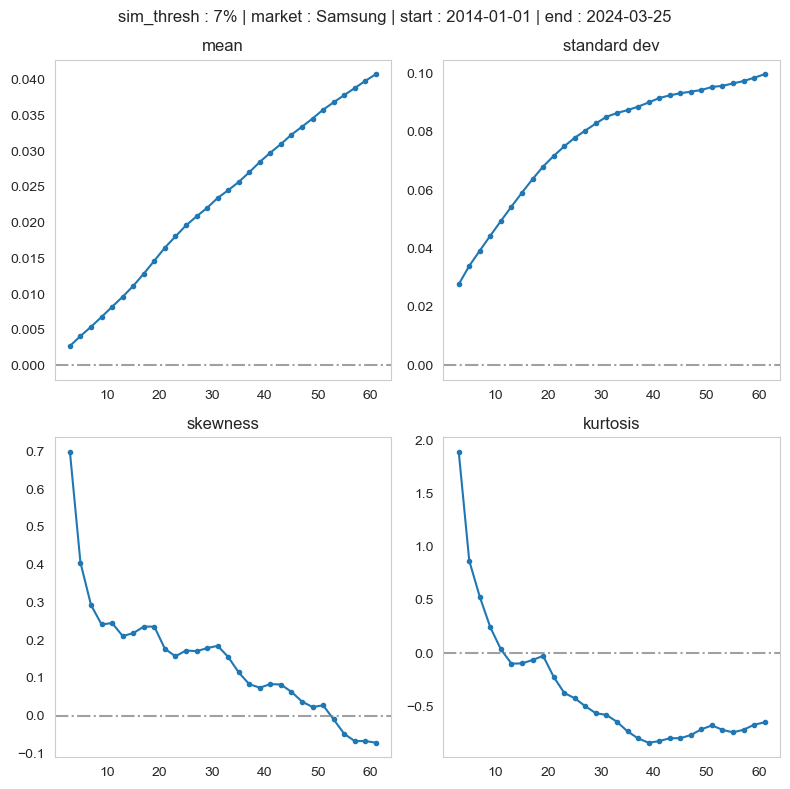

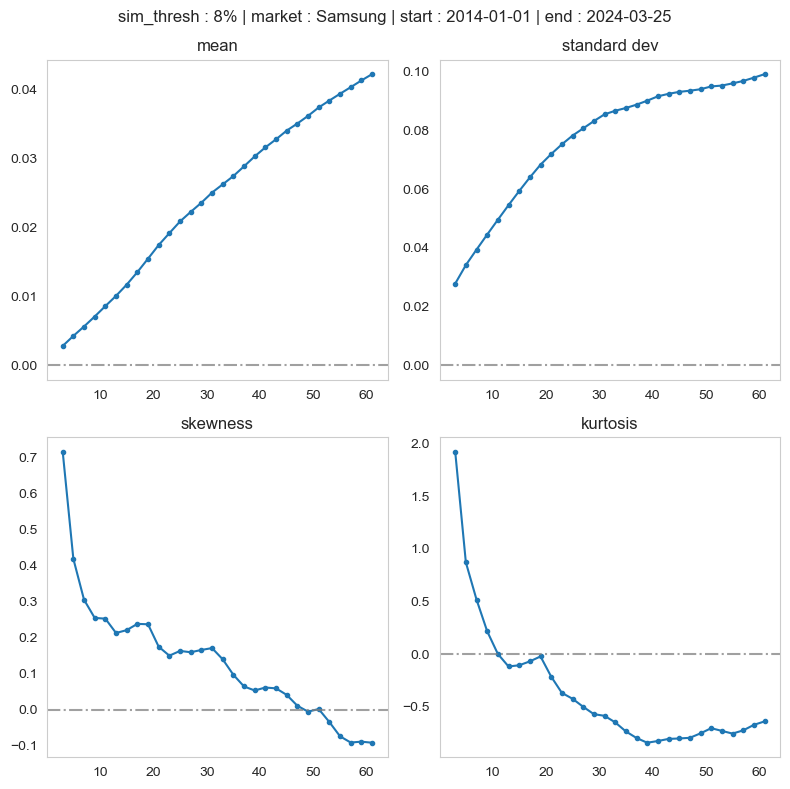

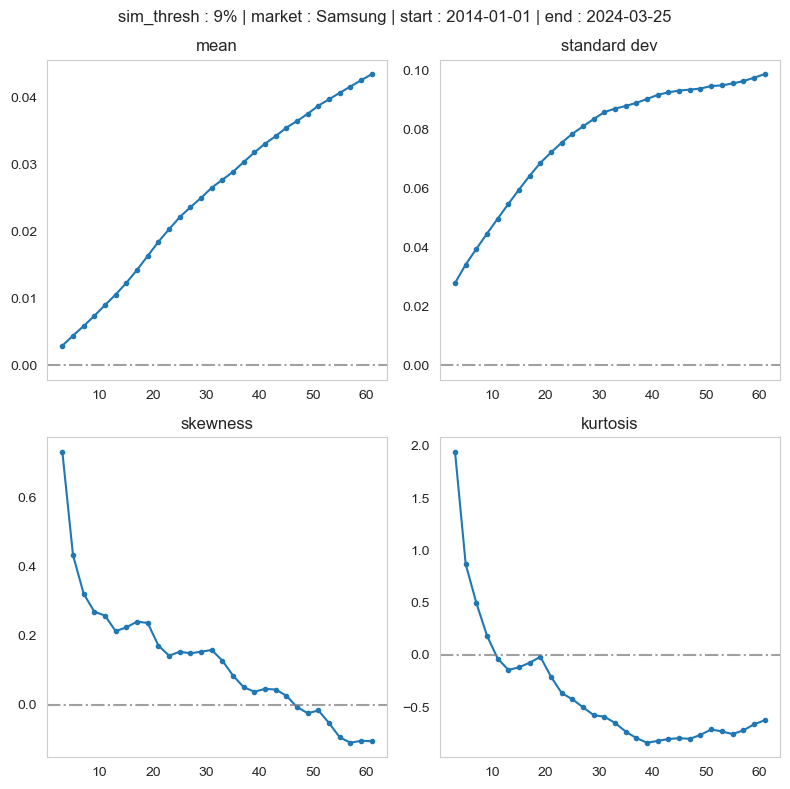

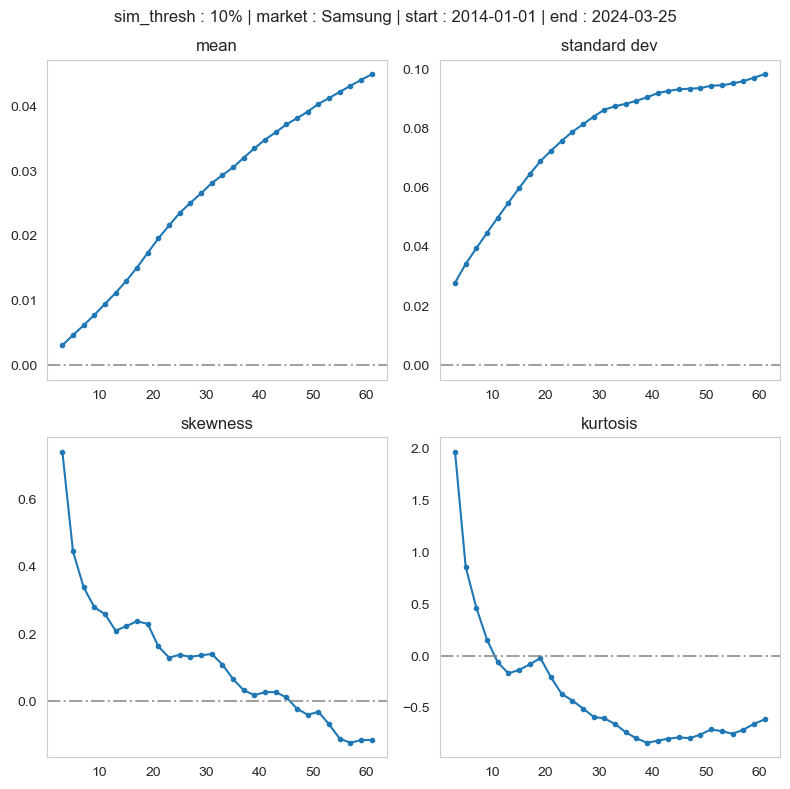

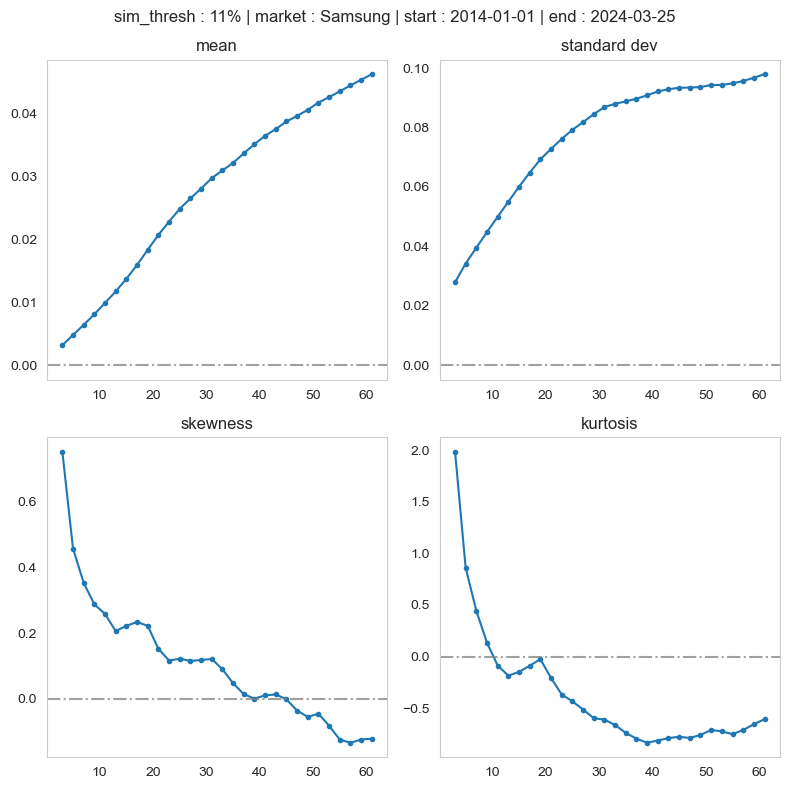

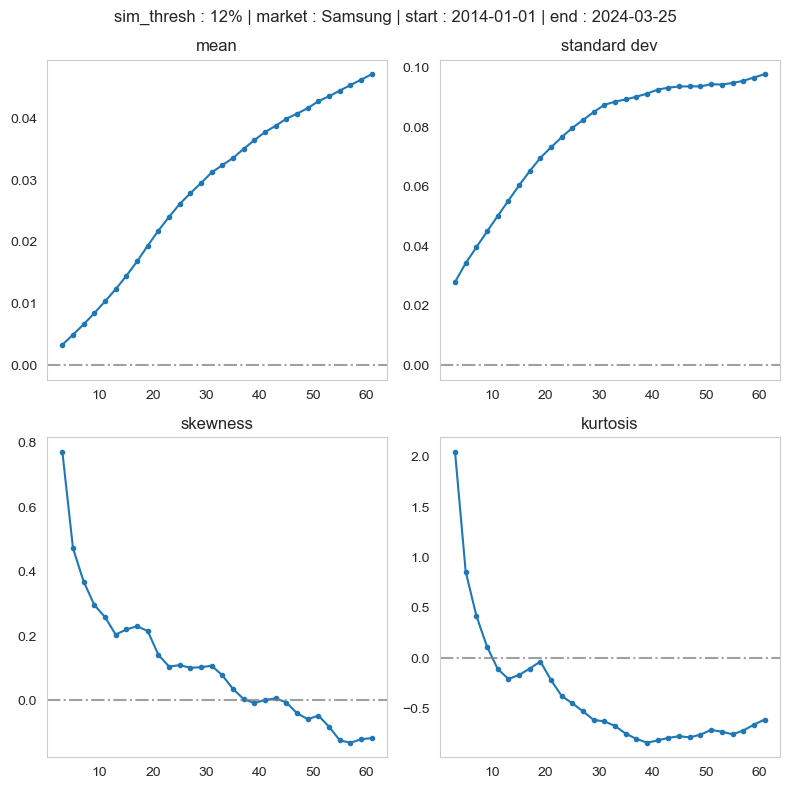

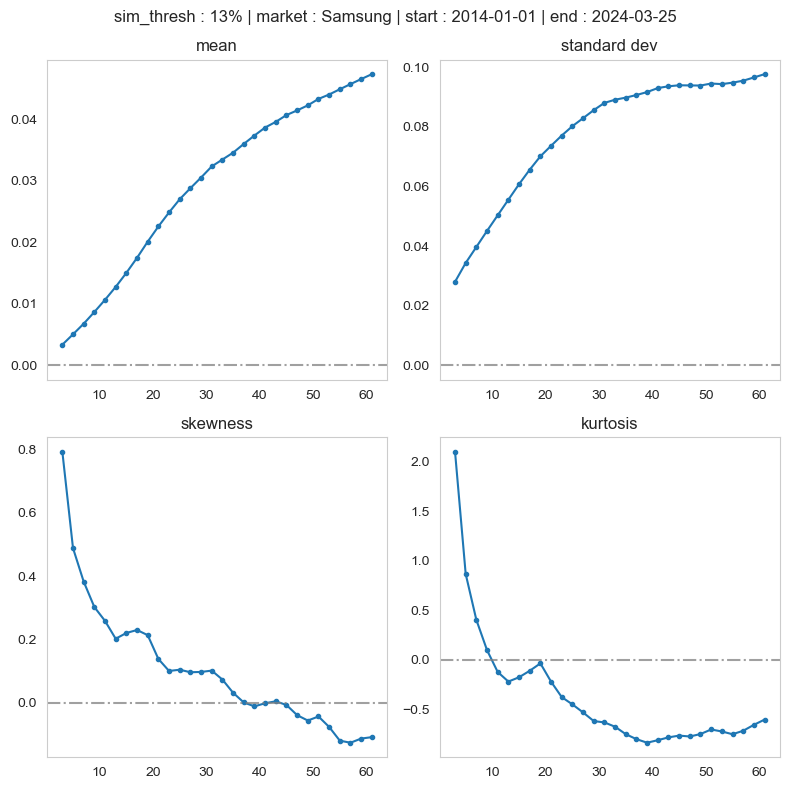

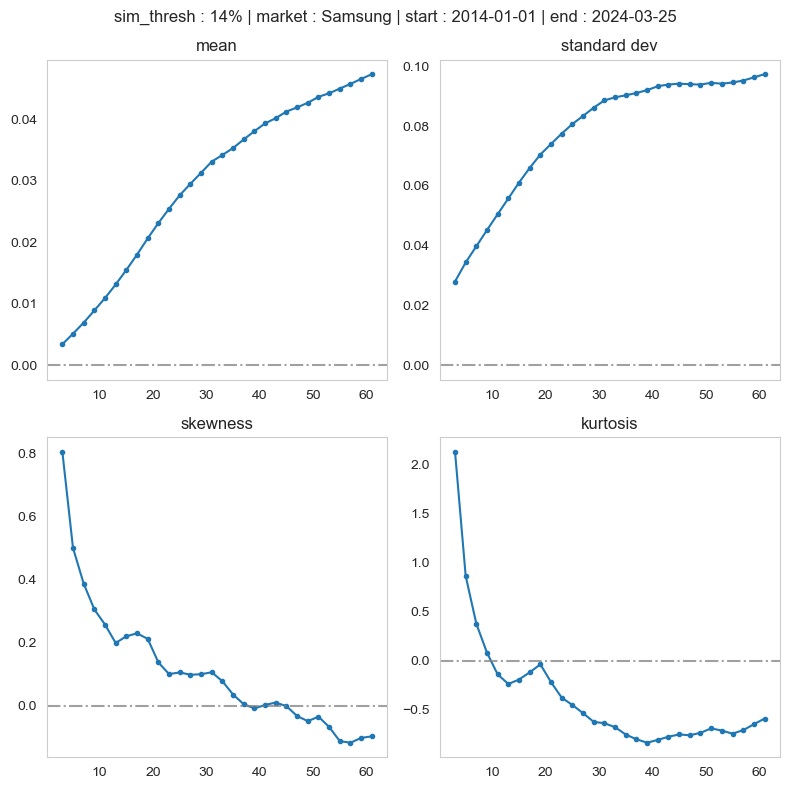

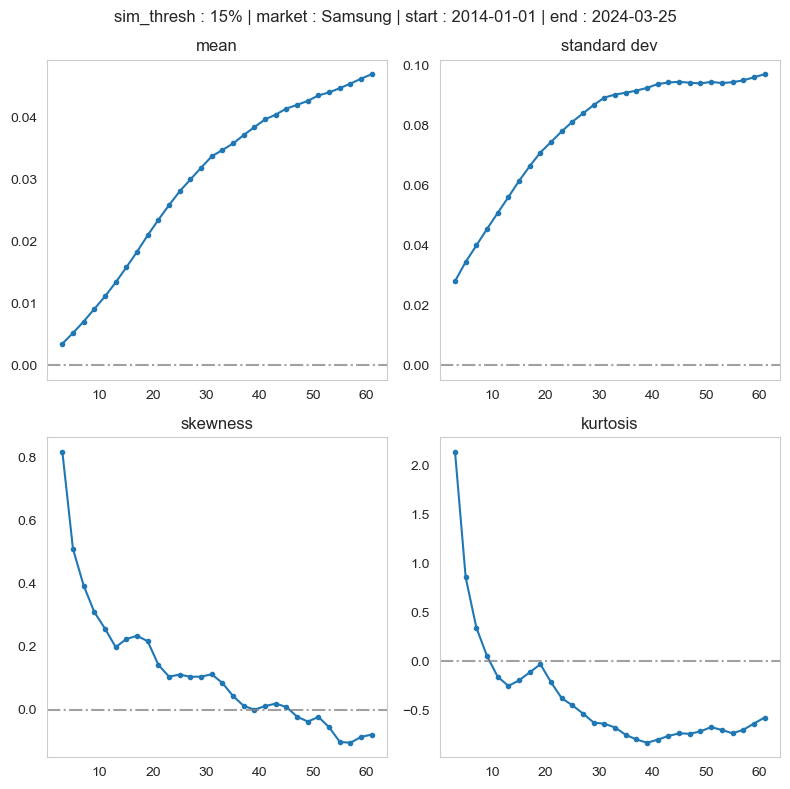

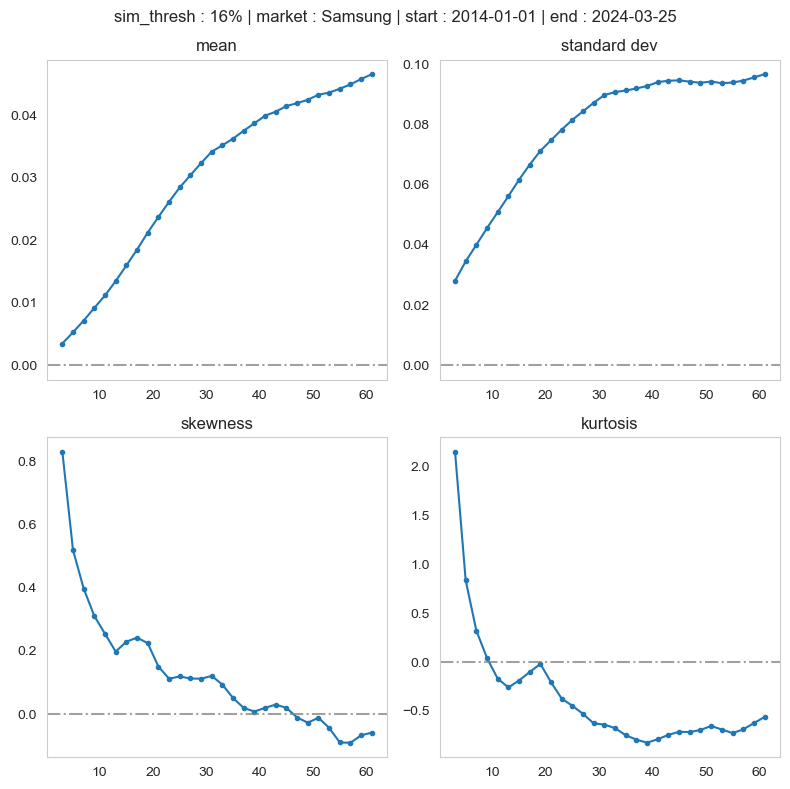

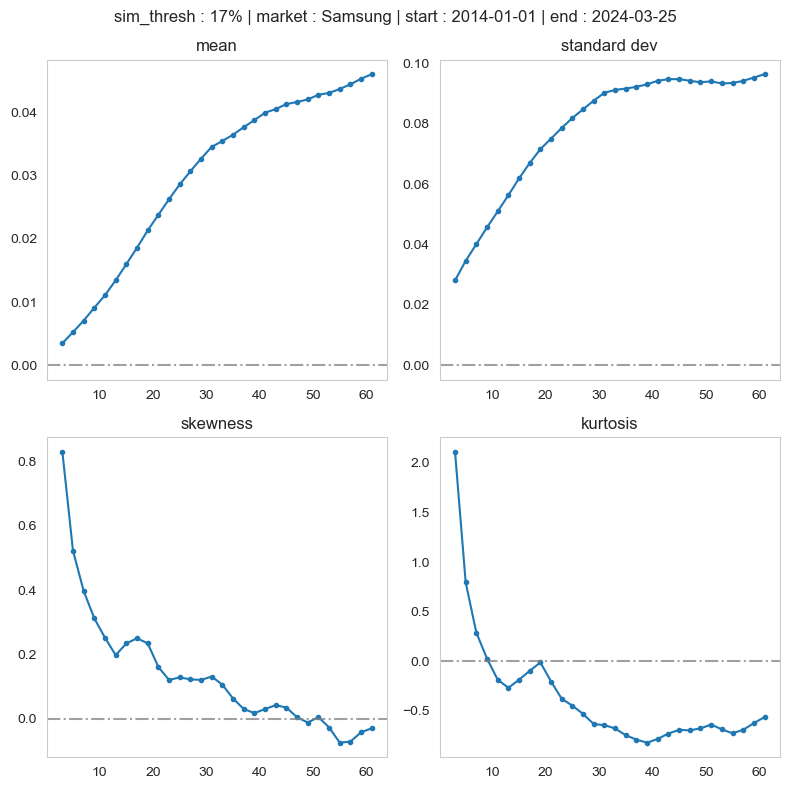

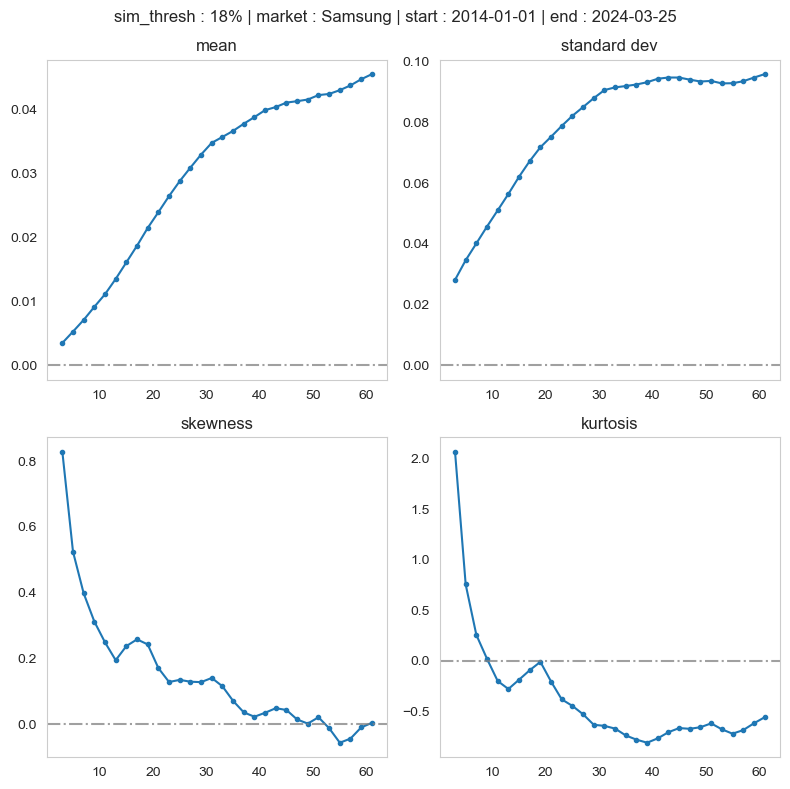

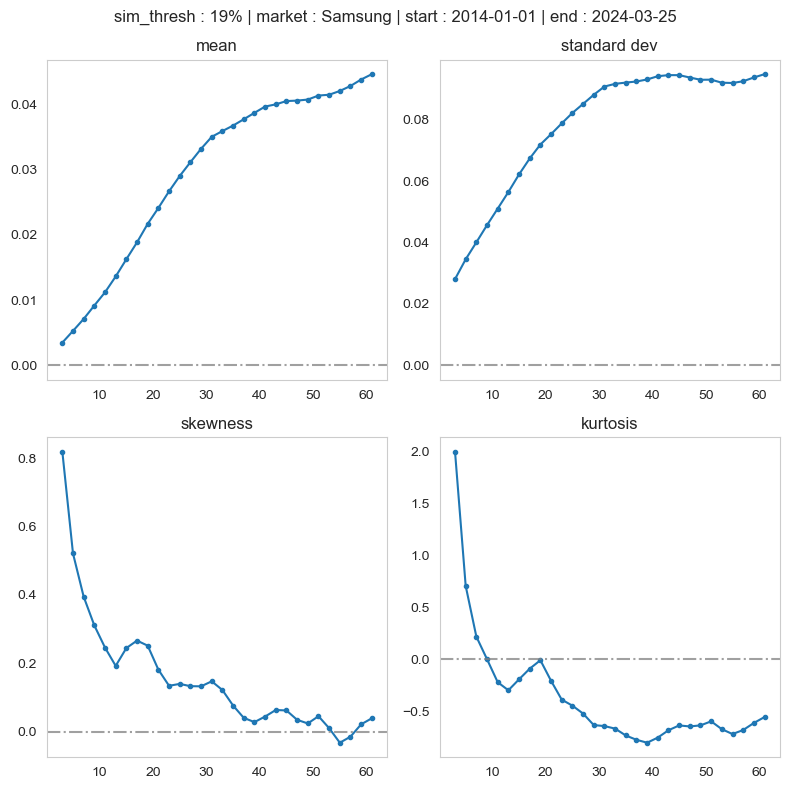

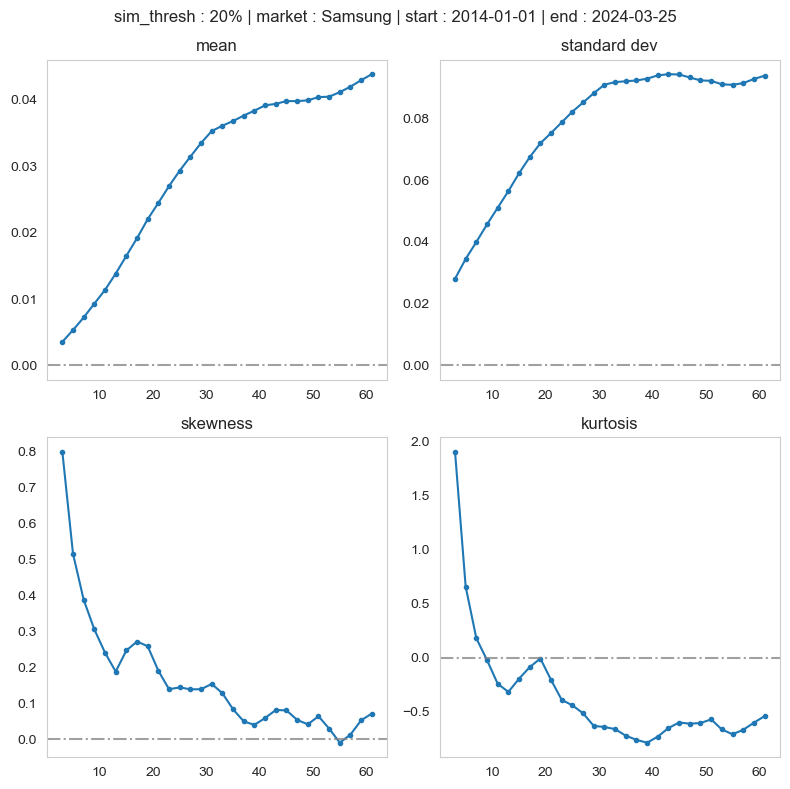

In [37]:
tick = 'Samsung'
for i in threshold :
    t = -i * 100
    pipeline(int(t), days, dataframes, tick)